In [177]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
import joblib
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

In [178]:
file_path = "data/df_all.csv"
df_all = pd.read_csv(file_path)
df_all.head(3)

,Country,Freedom,GDP per Capita,Generosity,Healthy life expectancy,Perceptions of corruption,Score,Social support,Year
0,switzerland,0.665570000000000,1.396510000000000,0.296780000000000,0.941430000000000,0.419780000000000,7.587000000000000,1.349510000000000,2015
1,iceland,0.628770000000000,1.302320000000000,0.436300000000000,0.947840000000000,0.141450000000000,7.561000000000000,1.402230000000000,2015
2,denmark,0.649380000000000,1.325480000000000,0.341390000000000,0.874640000000000,0.483570000000000,7.527000000000000,1.360580000000000,2015


### **Features, target and split (70/30)**

In [179]:
predictors = ['GDP per Capita', 'Healthy life expectancy',
              'Social support', 'Freedom', 'Generosity',
              'Perceptions of corruption']
target = 'Score'

X = df_all[predictors]
y = df_all[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
df_all = df_all.copy()
df_all['key'] = df_all['Country'].str.strip().str.lower() + '|' + df_all['Year'].astype(str)

train_keys = set(df_all.loc[X_train.index, 'key'].tolist())
test_keys  = set(df_all.loc[X_test.index,  'key'].tolist())

import pandas as pd, os
os.makedirs("artifacts", exist_ok=True)

members = pd.DataFrame({'key': df_all['key'].unique()})
members['is_train'] = members['key'].isin(train_keys).astype(int)
members['is_test']  = members['key'].isin(test_keys).astype(int)
members.to_csv("artifacts/split_membership.csv", index=False)
print("Saved artifacts/split_membership.csv with flags train/test")

Saved artifacts/split_membership.csv with flags train/test


In [180]:
def eval_reg(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return r2, mae, rmse

results_70_30 = []

### **Linear Regression**

In [181]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

r2, mae, rmse = eval_reg(y_test, y_pred_lr)
print(f"Linear Regression | R²={r2}  MAE={mae}  RMSE={rmse}")

results_70_30.append({
    "Model": "Linear Regression",
    "R2": r2, "MAE": mae, "RMSE": rmse
})

Linear Regression | R²=0.7264804570581476  MAE=0.44863964540034085  RMSE=0.5843837245747755


In [182]:
X_train_sm = sm.add_constant(X_train)              
ols = sm.OLS(y_train, X_train_sm).fit()

print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     315.7
Date:                Thu, 06 Nov 2025   Prob (F-statistic):          6.20e-173
Time:                        18:37:22   Log-Likelihood:                -431.52
No. Observations:                 547   AIC:                             877.0
Df Residuals:                     540   BIC:                             907.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [183]:
coef = ols.params.rename('coef')
se   = ols.bse.rename('std_err')
tval = ols.tvalues.rename('t')
pval = ols.pvalues.rename('p_value')
ci   = ols.conf_int()
ci.columns = ['ci_low','ci_high']

tabla = pd.concat([coef, se, tval, pval, ci], axis=1).sort_values('p_value')
tabla.round(4)

,coef,std_err,t,p_value,ci_low,ci_high
const,2.234300000000000,0.091500000000000,24.427499999999998,0.000000000000000,2.054700000000000,2.414000000000000
GDP per Capita,1.084300000000000,0.097300000000000,11.141500000000001,0.000000000000000,0.893100000000000,1.275400000000000
Freedom,1.619600000000000,0.191200000000000,8.472000000000000,0.000000000000000,1.244100000000000,1.995200000000000
Social support,0.631100000000000,0.093700000000000,6.735500000000000,0.000000000000000,0.447000000000000,0.815100000000000
Healthy life expectancy,0.976400000000000,0.157300000000000,6.209300000000000,0.000000000000000,0.667500000000000,1.285300000000000
Perceptions of corruption,1.039600000000000,0.264600000000000,3.928900000000000,0.000100000000000,0.519800000000000,1.559400000000000
Generosity,0.403200000000000,0.205700000000000,1.960100000000000,0.050500000000000,-0.000900000000000,0.807300000000000


### **GridSearch (optimal α and l1_ratio if applicable)**

In [184]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_grid = {'model__alpha': np.logspace(-3, 2, 30)}  
lasso_grid = {'model__alpha': np.logspace(-3, 0, 30)}  
enet_grid  = {
    'model__alpha': np.logspace(-3, 0, 20),
    'model__l1_ratio': np.linspace(0.1, 0.9, 9)
}

ridge_search = GridSearchCV(ridge_pipe, ridge_grid,
                            scoring='neg_mean_absolute_error',
                            cv=cv, n_jobs=-1)
lasso_search = GridSearchCV(lasso_pipe, lasso_grid,
                            scoring='neg_mean_absolute_error',
                            cv=cv, n_jobs=-1)
enet_search  = GridSearchCV(enet_pipe,  enet_grid,
                            scoring='neg_mean_absolute_error',
                            cv=cv, n_jobs=-1)

ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)
enet_search.fit(X_train, y_train)

print(f"Ridge best α: {ridge_search.best_params_} | MAE_CV: {-ridge_search.best_score_:.6f}")
print(f"Lasso best α: {lasso_search.best_params_} | MAE_CV: {-lasso_search.best_score_:.6f}")
print(f"ElasticNet best params: {enet_search.best_params_} | MAE_CV: {-enet_search.best_score_:.6f}")

Ridge best α: {'model__alpha': 0.001} | MAE_CV: 0.425587
Lasso best α: {'model__alpha': 0.001} | MAE_CV: 0.425750
ElasticNet best params: {'model__alpha': 0.001, 'model__l1_ratio': 0.1} | MAE_CV: 0.425625


In [185]:
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.001, random_state=42))
])

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

r2, mae, rmse = eval_reg(y_test, y_pred_ridge)
print(f"Ridge (alpha=0.001) | R²={r2}  MAE={mae}  RMSE={rmse}")

results_70_30.append({
    "Model": "Ridge (α=0.001)",
    "R2": r2, "MAE": mae, "RMSE": rmse
})

Ridge (alpha=0.001) | R²=0.7264803884939637  MAE=0.44863971262444724  RMSE=0.5843837978196161


In [186]:
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.001, random_state=42, max_iter=10000))
])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

r2, mae, rmse = eval_reg(y_test, y_pred_lasso)
print(f"Lasso (alpha=0.001) | R²={r2}  MAE={mae}  RMSE={rmse}")

results_70_30.append({
    "Model": "Lasso (α=0.001)",
    "R2": r2, "MAE": mae, "RMSE": rmse
})

Lasso (alpha=0.001) | R²=0.7263914566218979  MAE=0.4487536084050048  RMSE=0.5844787930580745


In [187]:
enet = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.1, random_state=42, max_iter=10000))
])

enet.fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

r2, mae, rmse = eval_reg(y_test, y_pred_enet)
print(f"Elastic Net (α=0.001, l1_ratio=0.1) | R²={r2}  MAE={mae}  RMSE={rmse}")

results_70_30.append({
    "Model": "Elastic Net (α=0.001, l1=0.1)",
    "R2": r2, "MAE": mae, "RMSE": rmse
})

Elastic Net (α=0.001, l1_ratio=0.1) | R²=0.7264393674186016  MAE=0.4486829506146554  RMSE=0.5844276176264385


In [188]:
summary_70_30 = pd.DataFrame(results_70_30).sort_values("R2", ascending=False)
summary_70_30.reset_index(drop=True)

,Model,R2,MAE,RMSE
0,Linear Regression,0.726480457058148,0.448639645400341,0.584383724574775
1,Ridge (α=0.001),0.726480388493964,0.448639712624447,0.584383797819616
2,"Elastic Net (α=0.001, l1=0.1)",0.726439367418602,0.448682950614655,0.584427617626438
3,Lasso (α=0.001),0.726391456621898,0.448753608405005,0.584478793058074


### **Assumptions**

In [189]:
# Residuals

residuals = y_test - y_pred_lr
print("Mean of residuals:", residuals.mean().round(4))
print("Std. deviation of residuals:", residuals.std(ddof=1).round(4))

Mean of residuals: -0.0382
Std. deviation of residuals: 0.5844


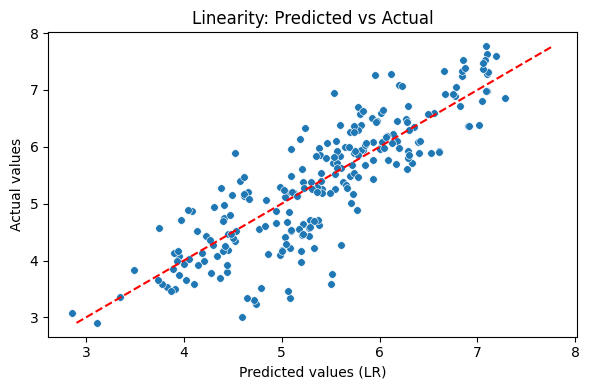

In [190]:
# Linearity: ŷ vs y

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_lr, y=y_test, s=30)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "--", color="red")
plt.xlabel("Predicted values (LR)")
plt.ylabel("Actual values")
plt.title("Linearity: Predicted vs Actual")
plt.tight_layout()
plt.show()

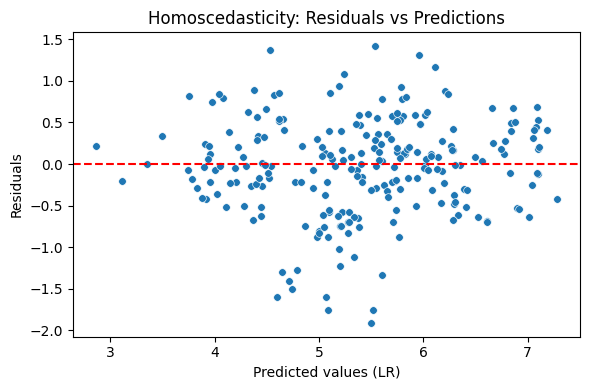

In [191]:
# Homoscedasticity: residuals vs ŷ
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_lr, y=residuals, s=30)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values (LR)")
plt.ylabel("Residuals")
plt.title("Homoscedasticity: Residuals vs Predictions")
plt.tight_layout()
plt.show()

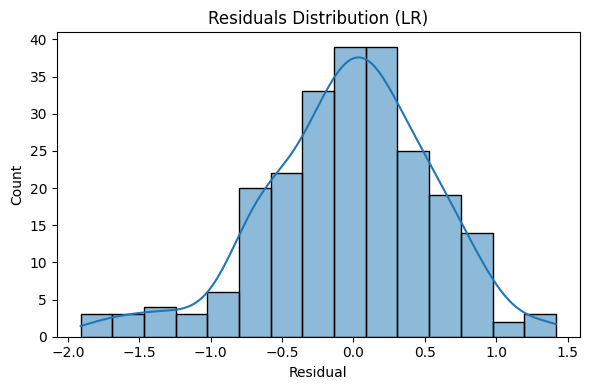

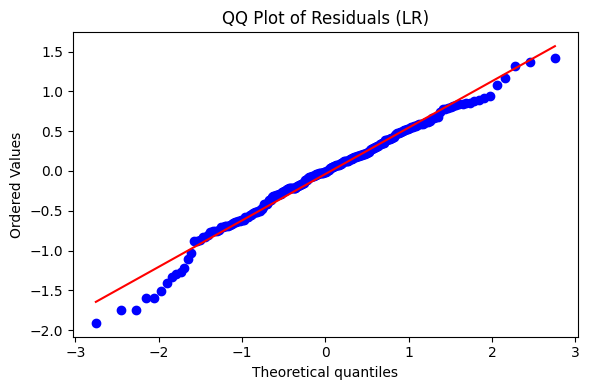

In [192]:
# Normality of residuals: histogram + QQ plot
import scipy.stats as stats

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution (LR)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (LR)")
plt.tight_layout()
plt.show()

In [193]:
# Independence: Durbin–Watson
import statsmodels.api as sm
dw = sm.stats.stattools.durbin_watson(residuals)
print("Durbin-Watson:", round(dw, 3))

Durbin-Watson: 2.209


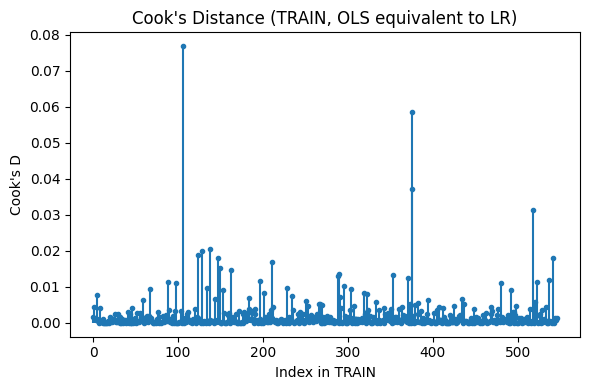

Observations with Cook's D > 0.05: 2


In [194]:
# Influence: Cook's Distance
X_train_const = sm.add_constant(X_train, has_constant="add")
ols_train = sm.OLS(y_train, X_train_const).fit()
influence = ols_train.get_influence()
cooks_d, _ = influence.cooks_distance

plt.figure(figsize=(6,4))
markerline, stemlines, baseline = plt.stem(np.arange(len(cooks_d)), cooks_d, basefmt=" ")
plt.setp(markerline, markersize=3)
plt.title("Cook's Distance (TRAIN, OLS equivalent to LR)")
plt.xlabel("Index in TRAIN")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()

threshold = 0.05
print(f"Observations with Cook's D > {threshold}: {int((cooks_d > threshold).sum())}")

In [195]:
# Breusch–Pagan (heteroscedasticity) and Jarque–Bera (normality)

X_test_const = sm.add_constant(X_test, has_constant="add")
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, X_test_const)
jb_stat, jb_p, _, _ = jarque_bera(residuals)

print(f"Breusch-Pagan: stat={bp_stat:.3f}, p-value={bp_p:.4f}")
print(f"Jarque-Bera:   stat={jb_stat:.3f}, p-value={jb_p:.4f}")

Breusch-Pagan: stat=12.168, p-value=0.0583
Jarque-Bera:   stat=11.560, p-value=0.0031


In [196]:
y_pred_train = lr.predict(X_train)
y_pred_test  = lr.predict(X_test)

In [197]:
def evaluate_regression_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"{dataset_name} | R²={r2:.6f}  MAE={mae:.6f}  RMSE={rmse:.6f}")
    
    plt.figure(figsize=(5.5, 4))
    sns.scatterplot(x=y_true, y=y_pred, s=30)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="--")
    plt.title(f"Predicho vs Real ({dataset_name})")
    plt.xlabel("Valor real")
    plt.ylabel("Predicción")
    plt.tight_layout()
    plt.show()
    
    return r2, mae, rmse

TRAIN
TRAIN | R²=0.778138  MAE=0.417069  RMSE=0.532560


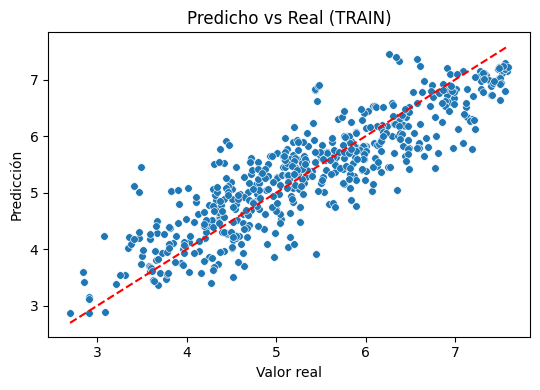

TEST
TEST | R²=0.726480  MAE=0.448640  RMSE=0.584384


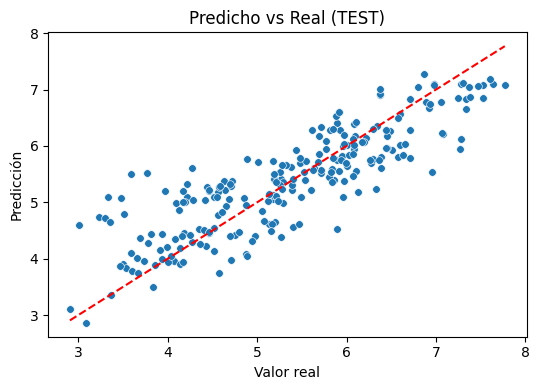

In [198]:
print("TRAIN")
r2_train, mae_train, rmse_train = evaluate_regression_model(y_train, y_pred_train, "TRAIN")

print("TEST")
r2_test, mae_test, rmse_test = evaluate_regression_model(y_test, y_pred_test, "TEST")

In [199]:
os.makedirs("model", exist_ok=True)
model_path = "model/happiness_regression.pkl"
joblib.dump(lr, model_path)

print(f"Model successfully saved to: {model_path}")

Model successfully saved to: model/happiness_regression.pkl
